In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import torch.linalg as LA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
All_state_var_train_points = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSC/All_state_var_train_points.csv")
All_opt_var_train_points = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSC/All_opt_var_train_points.csv")

All_state_var_valid_points = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSC/All_state_var_valid_points.csv")
All_opt_var_valid_points = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSC/All_opt_var_valid_points.csv")

In [17]:
All_state_var_train_points.columns = ['Vb', 'Vs', 'V', 'SOC']
All_opt_var_train_points.columns = ['J', 'V', 'SOC','I']

state_train = All_state_var_train_points[['Vb', 'Vs']]
opt_train = All_opt_var_train_points[['V', 'SOC','I']]

All_state_var_valid_points.columns = ['Vb', 'Vs', 'V', 'SOC']
All_opt_var_valid_points.columns = ['J', 'V', 'SOC','I']

state_test = All_state_var_valid_points[['Vb', 'Vs']]
opt_test = All_opt_var_valid_points[['V', 'SOC','I']]

In [18]:
state_train.values

array([[0.59850595, 0.63648748],
       [0.61071965, 0.6661089 ],
       [0.62403768, 0.67889595],
       ...,
       [0.89330659, 0.8996828 ],
       [0.89454071, 0.89913119],
       [0.89546324, 0.89896449]])

In [19]:
class optM(nn.Module):
  def __init__(self, layers, activations):
    super().__init__()
    if len(activations) != len(layers) - 2:
      raise ValueError("len(activations) doit être = nb couches cachées")

    modules = []

    for i in range(len(layers) - 1):
      modules.append(nn.Linear(layers[i], layers[i+1]))
      if i < len(activations):
        modules.append(activations[i])
    self.net = nn.Sequential(*modules)

  def forward(self, X):
    return self.net(X)

In [20]:
Cb = 9913
Cs = 887

Rb = 0.025
Rs = 0

device = "cuda" if torch.cuda.is_available() else "cpu"

A = torch.tensor([
    [-1.0/(Cb*(Rb + Rs)),  1.0/(Cb*(Rb + Rs))],
    [ 1.0/(Cs*(Rb + Rs)), -1.0/(Cs*(Rb + Rs))]
], dtype=torch.float32, device=device)
B = torch.tensor([
    [Rs/(Cb*(Rb+Rs))],
    [Rb/(Cs*(Rb+Rs))]
], dtype=torch.float32, device=device)


b0 = 0.09
b1 = 0.35
b3 = 10

a0 = 3.2
a1 = 3.041
a2 = -11.475
a3 = 24.457
a4 = -23.536
a5 = 8.513

dt = 60.0

# Matrice augmentée 3x3
M = torch.zeros((3, 3), dtype=torch.float32, device=device)
M[0:2, 0:2] = A
M[0:2, 2:3] = B

Md = torch.matrix_exp(M * dt)

Phi = Md[0:2, 0:2]       # (2x2)
Gamma = Md[0:2, 2:3]     # (2x1)

In [21]:
def soc_fn(Vb, Vs):
  return (Cb*Vb + Cs*Vs) / (Cb + Cs)

def u_ocp(Vs):
  return a0 + a1*Vs + a2*Vs**2 + a3*Vs**3 + a4*Vs**4 + a5*Vs**5

def r0_fn(soc):
  return b0 + b1*torch.exp(-b3 * (1.0 - soc))

def vtr_fn(u, r0, I):
  return u + r0 * I

def next_state(Vb_k, Vs_k, I_next):
  # Vb_k, Vs_k, I_next: (N, 1)
  x_k = torch.cat([Vb_k, Vs_k], dim=1)     # (N, 2)
  x_next = x_k @ Phi.T + I_next @ Gamma.T  # (N, 2)

  Vb_next = x_next[:, 0:1]
  Vs_next = x_next[:, 1:2]
  return Vb_next, Vs_next

In [22]:
def train_optM(model, optimizer, X_train, y_train, epochs=5000):
  model.to(device)
  loss_history = []

  for epoch in range(epochs):
    model.train()


    Vb = X_train[:, 0:1]   # (N, 1)
    Vs = X_train[:, 1:2]   # (N, 1)

    y_pred = model(X_train)

    V_next   = y_pred[:, 0:1]
    soc_next = y_pred[:, 1:2]
    I_next   = y_pred[:, 2:3]

    Vb_next, Vs_next = next_state(Vb, Vs, I_next)
    u                        = u_ocp(Vs_next)
    r0                       = r0_fn(soc_next)

    loss   = ((y_pred - y_train)**2).mean()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 1000 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, loss = {loss.item():.4e}")
  return loss_history

In [23]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Training Loss', color='blue')
    plt.yscale('log')  # Optionnel : utile si la perte diminue de plusieurs ordres de grandeur
    plt.xlabel('Époques')
    plt.ylabel('Perte (MSE)')
    plt.title('Évolution de la perte pendant l\'entraînement')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

In [24]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [25]:
# X_train → états : (Vb, Vs, température, etc…)
X_train_np = state_train.values
y_train_np = opt_train.values

# Fit sur training set
X_train_scaled = scaler_X.fit_transform(X_train_np)
y_train_scaled = scaler_y.fit_transform(y_train_np)

# Convertir en tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32, device=device)


Epoch 0, loss = 1.0851e+00
Epoch 1000, loss = 6.2501e-03
Epoch 2000, loss = 3.1992e-03
Epoch 3000, loss = 2.0208e-03
Epoch 4000, loss = 1.1047e-03
Epoch 5000, loss = 6.0140e-04
Epoch 6000, loss = 3.4603e-04
Epoch 7000, loss = 2.2120e-04
Epoch 8000, loss = 1.6308e-04
Epoch 9000, loss = 1.2537e-04
Epoch 10000, loss = 9.9762e-05
Epoch 11000, loss = 8.4688e-05
Epoch 12000, loss = 7.3993e-05
Epoch 13000, loss = 6.5651e-05
Epoch 14000, loss = 6.1570e-05
Epoch 15000, loss = 5.7031e-05
Epoch 16000, loss = 5.3019e-05
Epoch 17000, loss = 5.0864e-05
Epoch 18000, loss = 4.7492e-05
Epoch 19000, loss = 4.9662e-05
Epoch 19999, loss = 4.5867e-05


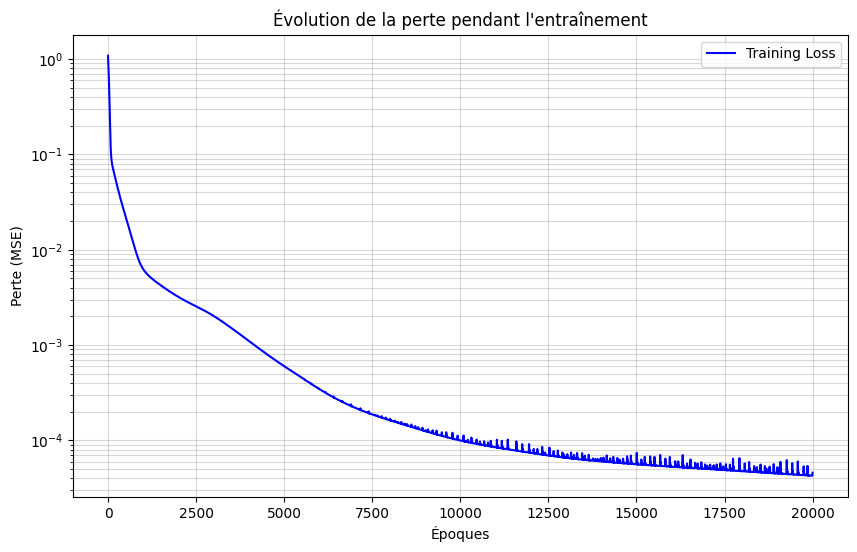

In [26]:
layers = [2, 20, 20, 3]
activations = [nn.Tanh(), nn.Tanh()]

model = optM(layers, activations).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = train_optM(model, optimizer, X_train_t, y_train_t, epochs=20000)
plot_loss(history)

In [27]:
X_test_scaled = scaler_X.transform(state_test.values)
y_test_scaled = scaler_y.transform(opt_test.values)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32, device=device)

# Unscale predictions

model.eval()
with torch.no_grad():
  y_test_pred_scaled = model(X_test_t).detach().cpu().numpy()

y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [28]:
y_true = opt_test.values
mse = ((y_test_pred - y_true)**2).mean()
print("MSE =", mse)

MSE = 1.2766653585673685e-05


/tmp/ipython-input-147744675.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


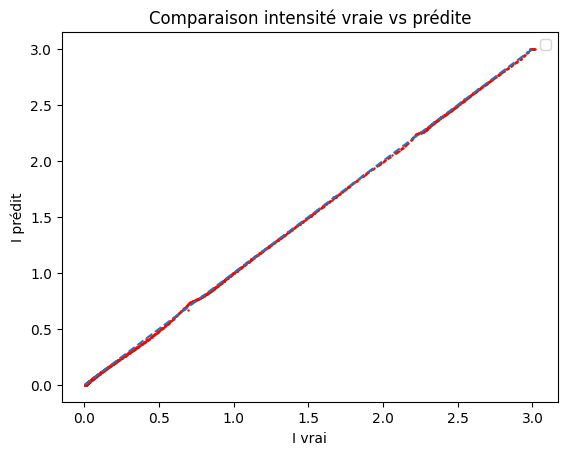

In [29]:
plt.scatter(y_test_pred[:, 2], y_true[:, 2], s=0.5, color='red')
plt.plot([0, 3], [0, 3], '--')
plt.xlabel("I vrai")
plt.ylabel("I prédit")
plt.title("Comparaison intensité vraie vs prédite")
plt.legend()
plt.show()


As we now have the model, we will build a close loop to simulate the charging of a battery based on different initial states for Vb0 and Vs0.

In [30]:
def closeLoop(model, Vs0, Vb0, N_max, SOC_final, dt,
              scaler_X=None, scaler_y=None, device=torch.device("cpu")):
    """
    Runs a closed-loop charging simulation using a PyTorch model as controller.
    The model receives the current battery state (Vb, Vs) and predicts the next
    charging current I_k. The state is then propagated with the NDC model.
    """

    # Make sure the model is ready for inference
    model.to(device)
    model.eval()

    # Store trajectories for plotting
    Vb = [Vb0]
    Vs = [Vs0]
    SOC = [float(soc_fn(Vb0, Vs0))]
    I_pred = []
    Vtr = []

    # Track the health constraint (Vs - Vb <= -0.04*SOC + 0.08)
    health = {
        "lhs": [Vs0 - Vb0],
        "rhs": [-0.04 * SOC[0] + 0.08]
    }

    iterations = 0

    # ----------------------------
    # Closed-loop iteration
    # ----------------------------
    while SOC[-1] < SOC_final and iterations < N_max:

        # Extract scalar values for Vb and Vs (they may be tensors or floats)
        Vb_val = float(Vb[-1].item()) if isinstance(Vb[-1], torch.Tensor) else float(Vb[-1])
        Vs_val = float(Vs[-1].item()) if isinstance(Vs[-1], torch.Tensor) else float(Vs[-1])

        # Build input for the model
        x_np = np.array([[Vb_val, Vs_val]], dtype=np.float32)
        if scaler_X is not None:
            x_np = scaler_X.transform(x_np)

        X_input = torch.from_numpy(x_np).to(device)

        # Predict model output
        with torch.no_grad():
            y_pred = model(X_input)

        # ------------------------------------------------------
        # Handle different model output formats:
        #   * model returns a tuple ( ... , I )
        #   * model returns a tensor [V_pred, soc_pred, I_pred]
        #   * optionally handle scaling on y
        # ------------------------------------------------------
        if isinstance(y_pred, tuple):
            # Assume last element is I
            I_k_tensor = y_pred[-1]
            if I_k_tensor.ndim == 1:
                I_k_tensor = I_k_tensor.view(-1, 1)  # Ensure shape (1,1)

        else:
            # Tensor output
            if scaler_y is not None:
                # Unscale predicted outputs
                y_np = y_pred.cpu().numpy()
                y_unscaled = scaler_y.inverse_transform(y_np)
                I_k_scalar = float(y_unscaled[0, 2])
                I_k_tensor = torch.tensor([[I_k_scalar]], dtype=torch.float32, device=device)
            else:
                # Take the 3rd component as current
                I_k_tensor = y_pred[:, 2:3]  # (1,1)

        # Convert to scalar for storage
        I_k_scalar = float(I_k_tensor.item())
        I_pred.append(I_k_scalar)

        # --------------------------------------
        # Propagate through NDC battery model
        # --------------------------------------
        Vb_k_tensor = torch.tensor([[Vb_val]], dtype=torch.float32, device=device)
        Vs_k_tensor = torch.tensor([[Vs_val]], dtype=torch.float32, device=device)

        # Get next voltages
        Vb_k1, Vs_k1 = next_state(Vb_k_tensor, Vs_k_tensor, I_k_tensor)

        # Store them (tensor or float, we will clean at end)
        Vb.append(Vb_k1)
        Vs.append(Vs_k1)

        # --------------------------------------
        # Compute SOC
        # --------------------------------------
        soc_k = soc_fn(Vb_k1, Vs_k1)
        soc_k_val = float(soc_k.item()) if isinstance(soc_k, torch.Tensor) else float(soc_k)
        SOC.append(soc_k_val)

        # --------------------------------------
        # Compute terminal voltage
        # --------------------------------------
        ocv = u_ocp(Vs_k1)
        r0 = r0_fn(soc_k)
        Vtr_k = vtr_fn(ocv, r0, I_k_tensor)
        Vtr.append(float(Vtr_k.item()))

        # --------------------------------------
        # Update health constraint tracking
        # --------------------------------------
        health["lhs"].append(float((Vs_k1 - Vb_k1).item()))
        health["rhs"].append(float(-0.04 * soc_k_val + 0.08))

        iterations += 1

    # ----------------------------
    # Convert Vb/Vs to plain floats
    # ----------------------------
    Vb_out = [float(v.item()) if isinstance(v, torch.Tensor) else float(v) for v in Vb]
    Vs_out = [float(v.item()) if isinstance(v, torch.Tensor) else float(v) for v in Vs]

    # Final structured output
    return {
        "Vb": Vb_out,
        "Vs": Vs_out,
        "SOC": SOC,
        "I": I_pred,
        "Vtr": Vtr,
        "health": health,
        "iterations": iterations
    }


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)
def plot_results(results, dt):
    """
    Plots the evolution of Vb, Vs, SOC, current I, terminal voltage,
    and checks if the health constraint is violated.
    """

    # Time axis in minutes
    time = [k * dt / 60 for k in range(results["iterations"])]

    # results extraction
    Vb  = results["Vb"][:results["iterations"]]
    Vs  = results["Vs"][:results["iterations"]]
    SOC = results["SOC"][:results["iterations"]]
    I   = results["I"][:results["iterations"]]
    Vtr = results["Vtr"][:results["iterations"]]

    lhs = results["health"]["lhs"][:results["iterations"]]
    rhs = results["health"]["rhs"][:results["iterations"]]


    # ==========================================================
    # FIGURE 1 : Vb/Vs + SOC + Current (compact 2x2 layout)
    # ==========================================================
    plt.figure(figsize=(15, 12))

    # 1) Vb and Vs
    plt.subplot(2, 2, 1)
    plt.plot(time, Vb, label="Vb (bulk)")
    plt.plot(time, Vs, label="Vs (surface)")
    plt.xlabel("Time [min]")
    plt.ylabel("Voltages [V]")
    plt.title("Evolution of Vb and Vs")
    plt.legend()

    # 2) SOC
    plt.subplot(2, 2, 2)
    plt.plot(time, SOC, label="SOC", color="green")
    plt.axhline(0.9, linestyle="--", color="black", alpha=0.7, label="SOC target (0.9)")
    plt.xlabel("Time [min]")
    plt.ylabel("State of Charge")
    plt.ylim(0, 1)
    plt.title("SOC evolution")
    plt.legend()

    # 3) Current
    plt.subplot(2, 2, 3)
    plt.plot(time, I, label="Current I [A]", color="orange")
    plt.axhline(3, linestyle="--", color="red", alpha=0.7, label="I max = 3A")
    plt.xlabel("Time [min]")
    plt.ylabel("Current [A]")
    plt.title("Charging current")
    plt.legend()

    plt.tight_layout()
    plt.show()


    # ==========================================================
    # FIGURE : Terminal Voltage + Health Constraint (same figure)
    # ==========================================================
    plt.figure(figsize=(10, 8))

    # ----------------------------------------------------------
    # Subplot 1 : Terminal voltage
    # ----------------------------------------------------------
    plt.subplot(2, 1, 1)
    plt.plot(time, Vtr, label="Terminal voltage Vtr", color="purple")
    plt.axhline(4.2, linestyle="--", color="red", alpha=0.7, label="Vtr max = 4.2V")

    plt.xlabel("Time [min]")
    plt.ylabel("Voltage [V]")
    plt.title("Terminal Voltage Evolution")
    plt.legend()
    plt.grid(True)


    # ----------------------------------------------------------
    # Subplot 2 : Health constraint
    # ----------------------------------------------------------
    plt.subplot(2, 1, 2)
    plt.plot(time, lhs, label="Vs - Vb", color="blue")
    plt.plot(time, rhs, label="Health limit", linestyle="--", color="black")

    plt.xlabel("Time [min]")
    plt.ylabel("Constraint value")
    plt.title("Health Constraint Check")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [40]:
# Configuration globale de l'esthétique
sns.set_theme(style="whitegrid", font_scale=1.1)

def plot_results(results, dt):
    """
    Plots the evolution of Vb, Vs, SOC, current I, terminal voltage,
    and checks if the health constraint is violated with forced dimensions.
    """

    # 1. Préparation des données
    time = [k * dt / 60 for k in range(results["iterations"])]
    Vb  = results["Vb"][:results["iterations"]]
    Vs  = results["Vs"][:results["iterations"]]
    SOC = results["SOC"][:results["iterations"]]
    I   = results["I"][:results["iterations"]]
    Vtr = results["Vtr"][:results["iterations"]]
    lhs = results["health"]["lhs"][:results["iterations"]]
    rhs = results["health"]["rhs"][:results["iterations"]]

    # ==========================================================
    # FIGURE 1 : État Interne (Vb/Vs, SOC, Courant)
    # On force une taille large (16x10 pouces)
    # ==========================================================
    fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig1.suptitle("Battery Internal States Analysis", fontsize=16, fontweight='bold')

    # 1) Vb and Vs
    axes[0, 0].plot(time, Vb, label="Vb (bulk)", linewidth=2)
    axes[0, 0].plot(time, Vs, label="Vs (surface)", linewidth=2)
    axes[0, 0].set_ylabel("Voltages [V]")
    axes[0, 0].set_title("Evolution of Vb and Vs")
    axes[0, 0].legend()

    # 2) SOC
    axes[0, 1].plot(time, SOC, label="SOC", color="green", linewidth=2)
    axes[0, 1].axhline(0.9, linestyle="--", color="black", alpha=0.7, label="Target (0.9)")
    axes[0, 1].set_ylabel("State of Charge")
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].set_title("SOC Evolution")
    axes[0, 1].legend()

    # 3) Current
    axes[1, 0].plot(time, I, label="Current I [A]", color="orange", linewidth=2)
    axes[1, 0].axhline(3, linestyle="--", color="red", alpha=0.7, label="I max = 3A")
    axes[1, 0].set_xlabel("Time [min]")
    axes[1, 0].set_ylabel("Current [A]")
    axes[1, 0].set_title("Charging Current")
    axes[1, 0].legend()

    # 4) On vide ou on supprime le 4ème quadrant si inutilisé
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste l'espacement pour le titre
    plt.show()

    # ==========================================================
    # FIGURE 2 : Contraintes de Sécurité (Vtr + Health)
    # On force une forme allongée (12x10 pouces) avec partage de l'axe X
    # ==========================================================
    fig2, (ax_v, ax_h) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig2.suptitle("Safety and Health Constraints", fontsize=16, fontweight='bold')

    # Subplot 1 : Terminal voltage
    ax_v.plot(time, Vtr, label="Terminal voltage Vtr", color="purple", linewidth=2)
    ax_v.axhline(4.2, linestyle="--", color="red", alpha=0.7, label="Vtr max = 4.2V")
    ax_v.set_ylabel("Voltage [V]")
    ax_v.set_title("Terminal Voltage Evolution")
    ax_v.legend(loc="lower right")

    # Subplot 2 : Health constraint
    ax_h.plot(time, lhs, label="Vs - Vb (LHS)", color="blue", linewidth=2)
    ax_h.plot(time, rhs, label="Health limit (RHS)", linestyle="--", color="black")
    ax_h.set_xlabel("Time [min]")
    ax_h.set_ylabel("Constraint Value")
    ax_h.set_title("Health Constraint Check")
    ax_h.legend(loc="lower right")

    # Ajustement fin pour éviter les chevauchements
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Ploting

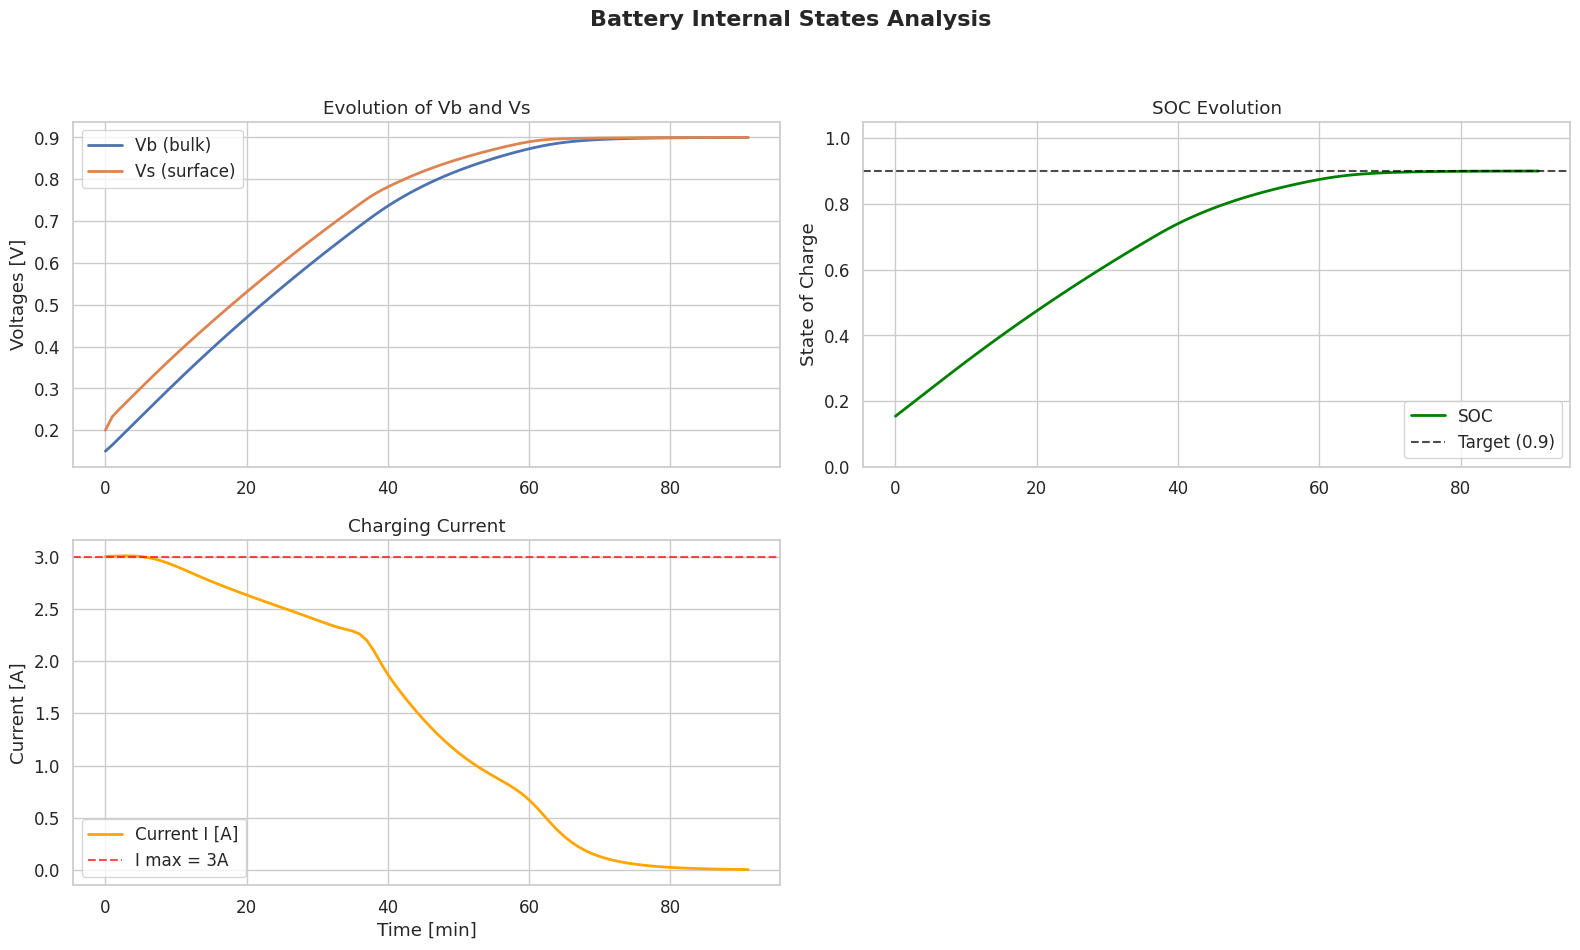

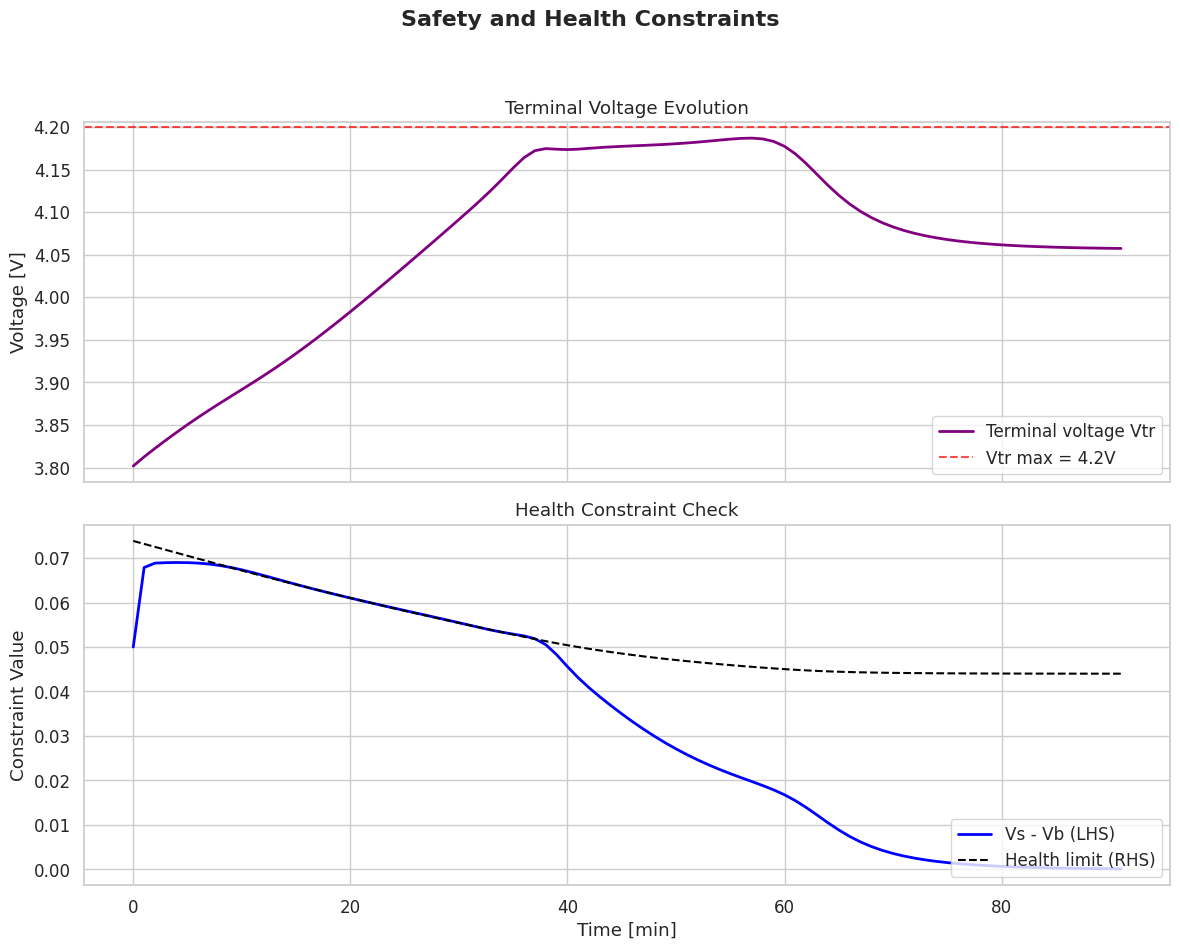

In [41]:
#We took 0.2 as initial values for Vb and Vs, and dt=60Sec means we maintain a constant current for 60 secondes before changing its value.
result = closeLoop(model,
                   Vs0=0.2,
                   Vb0=0.15,
                   N_max=100,
                   SOC_final=0.9,
                   dt=60,
                   scaler_X=scaler_X,
                   scaler_y=scaler_y,
                   device=device)

plot_results(result, dt=60)


Now, let's verify that our neural controller doesn't violate the constraints repected by the MPC which are:
- terminale voltage constraint
- health constraint
- current constraint

Generation of initiale value fo

In [33]:
def sample_initial_conditions(n_samples=100):
    Vb0_list = []
    Vs0_list = []

    for _ in range(n_samples):
        SOC0 = np.random.uniform(0.05, 0.8)
        delta = np.random.uniform(-0.05, 0.08)  # Vs - Vb

        # Compute Vb and Vs from SOC equation:
        # SOC = (Cb*Vb + Cs*Vs) / (Cb+Cs)
        # With Vs = Vb + delta
        # Solve for Vb :
        Vb0 = SOC0 - (Cs/(Cb+Cs))*delta
        Vs0 = Vb0 + delta

        # Clamp to feasible region
        Vb0 = np.clip(Vb0, 0.01, 0.9)
        Vs0 = np.clip(Vs0, 0.01, 0.9)

        Vb0_list.append(Vb0)
        Vs0_list.append(Vs0)

    return np.array(Vb0_list), np.array(Vs0_list)

# Example usage
Vb0_samples, Vs0_samples = sample_initial_conditions(100)


In [34]:
def evaluate_violations(model, Vb0_samples, Vs0_samples, N_sim, N_max, dt=60.0):
    """
    Runs N_sim closed-loop charging simulations starting from the provided
    initial conditions (Vb0_samples, Vs0_samples). Each simulation lasts N_max
    time steps. For every trajectory, the function checks:

        - current violations (I < 0 or I > 3)
        - terminal voltage violations (Vtr > 4.2)
        - health constraint violations (Vs - Vb > -0.04 * SOC + 0.08)

    It returns the mean number of violations per time step, averaged over all
    simulated points (N_sim * N_max).
    """

    # Count current violations for one simulation result
    def count_I_viol(result, I_max=3.0):
        I = result["I"]
        return sum((i < 0) or (i > I_max) for i in I)

    # Count terminal voltage violations
    def count_Vtr_viol(result):
        Vtr = result["Vtr"]
        return sum(v > 4.2 for v in Vtr)

    # Count health constraint violations
    def count_health_viol(result):
        lhs = result["health"]["lhs"]
        rhs = result["health"]["rhs"]
        return sum(l > r for l, r in zip(lhs, rhs))

    # Accumulators for violations across all simulations
    total_I_viol = 0
    total_Vtr_viol = 0
    total_health_viol = 0

    # Run each simulation
    for i in range(N_sim):
        Vb0 = Vb0_samples[i]
        Vs0 = Vs0_samples[i]

        res = closeLoop(
            model,
            Vs0=Vs0,
            Vb0=Vb0,
            N_max=N_max,
            SOC_final=0.9,
            dt=dt,
            scaler_X=scaler_X,
            scaler_y=scaler_y,
            device=device
        )

        total_I_viol      += count_I_viol(res)
        total_Vtr_viol    += count_Vtr_viol(res)
        total_health_viol += count_health_viol(res)

    # Total number of evaluated points
    total_points = N_sim * N_max

    mean_I_viol      = total_I_viol      / total_points
    mean_Vtr_viol    = total_Vtr_viol    / total_points
    mean_health_viol = total_health_viol / total_points

    return mean_I_viol, mean_Vtr_viol, mean_health_viol


In [42]:
Vb0_samples, Vs0_samples = sample_initial_conditions(10000)

mean_I, mean_Vtr, mean_health = evaluate_violations(
    model,
    Vb0_samples,
    Vs0_samples,
    N_sim=100,
    N_max=120,
)

print("Mean I violations:", mean_I)
print("Mean Vtr violations:", mean_Vtr)
print("Mean health violations:", mean_health)


Mean I violations: 0.011333333333333334
Mean Vtr violations: 0.0
Mean health violations: 0.10058333333333333
